# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь в страивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [21]:
!pip install "tensorflow==2.0.0"

     |████████████████████████████████| 102.7MB 3.5MB/s eta 0:00:01
     |████████████████████████████████| 450kB 8.1MB/s eta 0:00:01
     |████████████████████████████████| 3.8MB 5.5MB/s eta 0:00:01
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [1]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [2]:
from frustum_pointnets.models.model_util import placeholder_inputs
from frustum_pointnets.models.frustum_pointnets_v1 import get_model

In [3]:
from ssd import SSD
import pickle
import cv2
import numpy as np
import matplotlib.pylab as plt

### Построение модели и загрузка весов

In [359]:
def get_session_and_ops(batch_size, num_point):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(0)):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = get_model(pointclouds_pl, one_hot_vec_pl,
                is_training_pl)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, './frustum_model/frustum_pointnets_snapshots/log_v1/model.ckpt')
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points
              }
        return sess, ops

### Чтение калибровочных матриц

In [347]:
def get_matrices(mat_file):
    with open(mat_file, 'r') as file:
        matrices = [
            line.strip().split()
            for line in file.readlines()
        ][:-1]
        mat_keys = [mat[0][:-1] for mat in matrices]
        mat_values = [mat[1:] for mat in matrices]
        mat_values = [np.array(list(map(float, mat))).reshape((3, -1)) for mat in mat_values]
        
    mat_dict = dict(zip(mat_keys, mat_values))
    rect = np.zeros((4, 4))
    rect[:3, :3] = mat_dict['R0_rect']
    rect[-1, -1] = 1.0
    mat_dict['R0_rect'] = rect

    v2c = np.zeros((4, 4))
    v2c[:3, :4] = mat_dict['Tr_velo_to_cam']
    v2c[-1, -1] = 1.0
    mat_dict['Tr_velo_to_cam'] = v2c

    i2v = np.zeros((4, 4))
    i2v[:3, :4] = mat_dict['Tr_imu_to_velo']
    i2v[-1, -1] = 1
    mat_dict['Tr_imu_to_velo'] = i2v
    return mat_dict

### Загрузка данных по номеру изображения

In [348]:
def get_example(example_num, path='./training'):
    images_folder = path + '/image_2/'
    calib_folder = path + '/calib/'
    label_folder = path + '/label_2/'
    velodyne_folder = path + '/velodyne/'
    
    img_file = images_folder + example_num + '.png'
    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vel_file = velodyne_folder + example_num + '.bin'
    with open(vel_file, 'rb') as file:
        vel_data = np.fromfile(file, dtype=np.float32).reshape(-1, 4)
    mat_dict = get_matrices(calib_folder + example_num + '.txt')
    return {
        'img': img,
        'vel': vel_data,
        'mat': mat_dict
    }

#### Обработка bounding box

In [349]:
def bbox_to_vertices(bbox):
    return np.array([bbox[0], [bbox[0, 0], bbox[1, 1]], bbox[1], [bbox[1, 0], bbox[0, 1]], bbox[0]])

def bbox_scale(bbox, img):
    return (bbox * img.shape[:2]).astype(int)

### Класс для Frustum Pointnet 

In [350]:
def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape)-1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape)-1, keepdims=True)
    return probs


class FPN(object):
    def __init__(self, num_points):
        self.num_points = num_points
        self.sess, self.ops = get_session_and_ops(batch_size=None, num_point=num_points)
    
    def predict(self, data, one_hot_vec):
        batch_size = data.shape[0]
        logits = np.zeros((data.shape[0], data.shape[1], 2))
        centers = np.zeros((data.shape[0], 3))
        heading_logits = np.zeros((data.shape[0], 12))
        heading_residuals = np.zeros((data.shape[0], 12))
        size_logits = np.zeros((data.shape[0], 8))
        size_residuals = np.zeros((data.shape[0], 8, 3))
        scores = np.zeros((data.shape[0],)) # 3D box score 
        ep = self.ops['end_points'] 
        i = 0
        feed_dict = {
            self.ops['pointclouds_pl']: data,
            self.ops['one_hot_vec_pl']: one_hot_vec,
            self.ops['is_training_pl']: False
        }
        
        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            self.sess.run([self.ops['logits'], self.ops['center'],
                ep['heading_scores'], ep['heading_residuals'],
                ep['size_scores'], ep['size_residuals']],
                feed_dict=feed_dict)
        
        logits[i*batch_size:(i+1)*batch_size,...] = batch_logits
        centers[i*batch_size:(i+1)*batch_size,...] = batch_centers
        heading_logits[i*batch_size:(i+1)*batch_size,...] = batch_heading_scores
        heading_residuals[i*batch_size:(i+1)*batch_size,...] = batch_heading_residuals
        size_logits[i*batch_size:(i+1)*batch_size,...] = batch_size_scores
        size_residuals[i*batch_size:(i+1)*batch_size,...] = batch_size_residuals

        # Compute scores
        batch_seg_prob = softmax(batch_logits)[:,:,1] # BxN
        batch_seg_mask = np.argmax(batch_logits, 2) # BxN
        mask_mean_prob = np.sum(batch_seg_prob * batch_seg_mask, 1) # B,
        mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask,1) # B,
        heading_prob = np.max(softmax(batch_heading_scores),1) # B
        size_prob = np.max(softmax(batch_size_scores),1) # B,
        
        batch_scores = np.log(mask_mean_prob) + np.log(heading_prob) + np.log(size_prob)
        scores[i*batch_size:(i+1)*batch_size] = batch_scores 
        # Finished computing scores

        heading_cls = np.argmax(heading_logits, 1) # B
        size_cls = np.argmax(size_logits, 1) # B
        heading_res = np.array([heading_residuals[i,heading_cls[i]] \
            for i in range(data.shape[0])])
        size_res = np.vstack([size_residuals[i,size_cls[i],:] \
            for i in range(data.shape[0])])

        return np.argmax(logits, 2), centers, heading_cls, heading_res, \
            size_cls, size_res, scores
        

## Код пайплайна 

In [419]:
from collections import namedtuple

Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

class PipelineDetector(object):
    def __init__(self, frustum_pointnet, frustum_batch_size, ssd_detector, ssd_threshold):
        self.pointnet = frustum_pointnet
        self.batch_size = frustum_batch_size
        self.detector = ssd_detector
        self.threshold = ssd_threshold
    
    def predict(self, xyz, image, car_to_cam, intrinsics):
        # run 2D detector on the image
        detection = self.detector.predict(image)
        batch = []
        one_hot = []
            
        # TODO: process lidar point cloud and construct frustum examples
        
        # получаем калибровочные матрицы
        P2 = intrinsics['P2']
        R0 = intrinsics['R0_rect']
        V2C = car_to_cam

        # проецируем из облака точек в Rect camera координаты
        pts3d = xyz.copy()
        pts3d[:, 3] = 1.0
        to_rect = R0.dot(V2C)
        pts_rect = pts3d.dot(to_rect.T)
        
        # Теперь проецируем на изображение
        pts2d = pts_rect.dot(P2.T)
        pts_rect[:, 3] = xyz[:, 3]
        pts2d = (pts2d[:, :2] / pts2d[:, 2:])
        
        # Отбираем точки, которые лежат на изображении
        in_img = (pts2d[:, 0] > 0) & (pts2d[:, 0] < image.shape[1]) & \
            (pts2d[:, 1] > 0) & (pts2d[:, 1] < image.shape[0]) & (xyz[:, 0] > 0.0)
        pts2d = pts2d[in_img]
        
        # Проходимся по каждой детекции
        for idx in range(detection['num_detections']):
            # TODO: extract bounding boxes with vehicle classes and filter them by ssd_threshold
            # Если у нее скор ниже трешолда или на детекции не машина, пропускаем
            if detection['detection_scores'][idx] < self.threshold or detection['detection_classes'][idx] != 1:
                continue
            
            bbox = detection['detection_boxes'][idx].reshape(2, 2)
            bbox = bbox_scale(bbox, image)
            bbox_vert = bbox_to_vertices(bbox)
            
            # Выбираем точки внутри bbox
            in_box = (pts2d[:, 0] > bbox[0, 1]) & (pts2d[:, 0] < bbox[1, 1]) & \
                (pts2d[:, 1] > bbox[0, 0]) & (pts2d[:, 1] < bbox[1, 0])
            selected_points = pts_rect[in_img][in_box]
            
            # Если точек меньше, сэмплим их повторно и случайным образом
            # Если точек больше, берем случайное подмножество
            rand_idx = np.random.randint(len(selected_points) - 1, size=(self.pointnet.num_points,))
            selected_points = selected_points[rand_idx, :]

            plt.figure(figsize=(20, 10))
            plt.imshow(image)
            plt.scatter(pts2d[in_box][:, 0], pts2d[in_box][:, 1], s=1)
            
            # Добавляем в батч
            
            batch.append(selected_points)
            one_hot.append([1, 0, 0])
            
        batch = np.array(batch)
        one_hot = np.array(one_hot)
        # TODO: run frustum inference (use batch to accelerate inference per frame)
        if len(batch):
            result = self.pointnet.predict(batch, one_hot) # Отправляем полученный батч из детекций в поинтнет
        # TODO: construct Scene namedtuple and return it
            return result
        return None
    

#### Инициализация классов

In [420]:
fpn = FPN(1024)
detector = SSD('tmp')
model = PipelineDetector(fpn, 1, detector, 0.5)

INFO:tensorflow:Restoring parameters from ./frustum_model/frustum_pointnets_snapshots/log_v1/model.ckpt


### Проверим работу поинтнета на каком-нибудь примере:
по какой-то причине, большинство детекций получают nan'ы в скорах

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


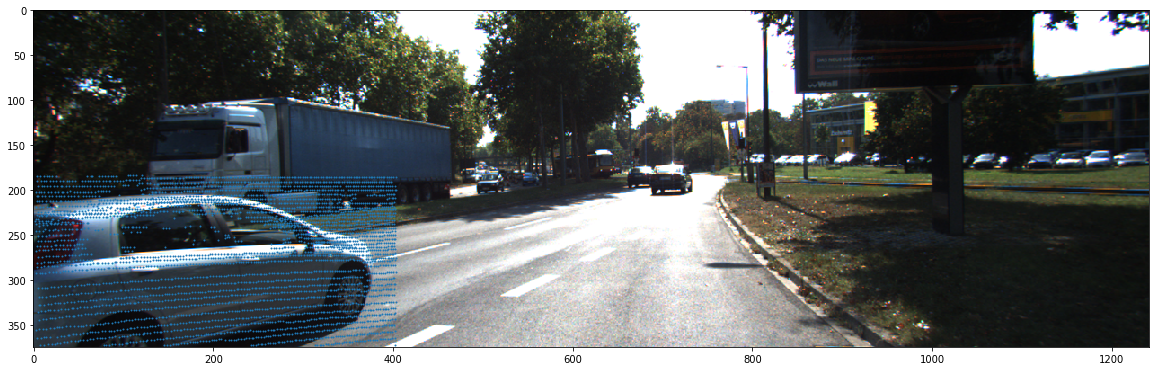

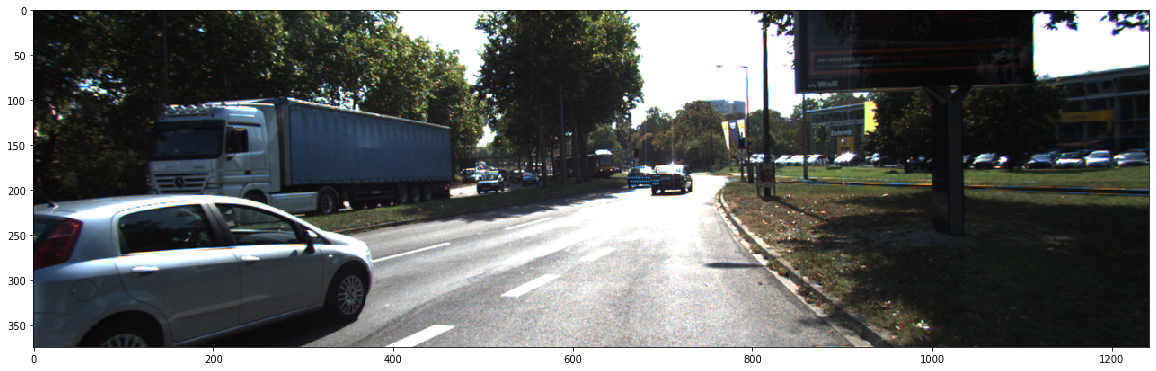

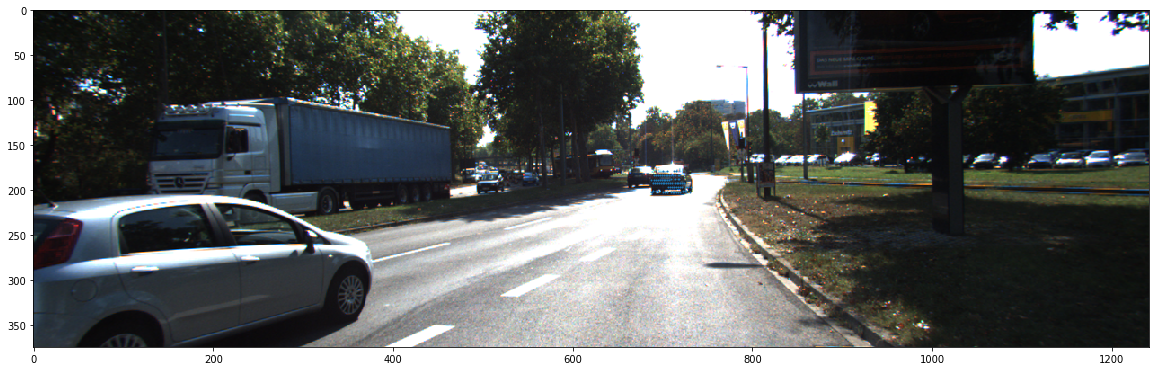

In [421]:
example = get_example('000016')
intrinsics = {
    'P2': example['mat']['P2'],
    'R0_rect': example['mat']['R0_rect']
}
result = model.predict(example['vel'], example['img'], example['mat']['Tr_velo_to_cam'], intrinsics)

In [418]:
print(result)

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), array([[-1.68902504,  0.88471448, 10.7808094 ],
       [ 3.2626307 ,  0.80738115, 43.63287735],
       [-0.07832035,  0.51981068, 16.28677559]]), array([0, 9, 6]), array([-0.19309625, -0.00492784,  0.06848597]), array([0, 0, 0]), array([[ 0.20210168,  0.02345579,  0.13918474],
       [-0.407657  , -0.07609081,  0.00305856],
       [-0.01460175, -0.03115009,  0.02388102]]), array([        nan, -2.22760892,         nan]))


### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [19]:
import numpy as np
from matplotlib import pyplot as plt 

In [36]:
xyzi = np.fromfile('../kitti_dataset/training/velodyne/000100.bin', dtype=np.float32).reshape(-1, 4)

In [37]:
xyzi

array([[43.889,  0.084,  1.693,  0.   ],
       [43.201,  0.218,  1.67 ,  0.   ],
       [42.397,  0.347,  1.643,  0.   ],
       ...,
       [ 3.696, -1.398, -1.726,  0.31 ],
       [ 3.717, -1.399, -1.736,  0.35 ],
       [ 3.724, -1.389, -1.737,  0.   ]], dtype=float32)

(-50, 50)

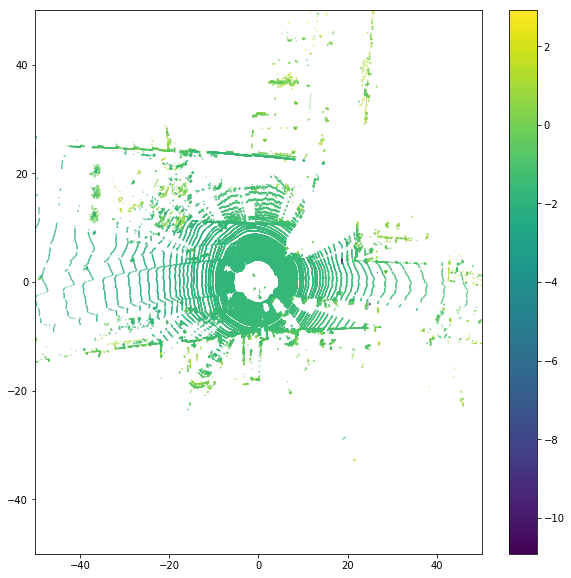

In [43]:
plt.figure(figsize=(10, 10))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c=xyzi[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)

In [39]:
import Image

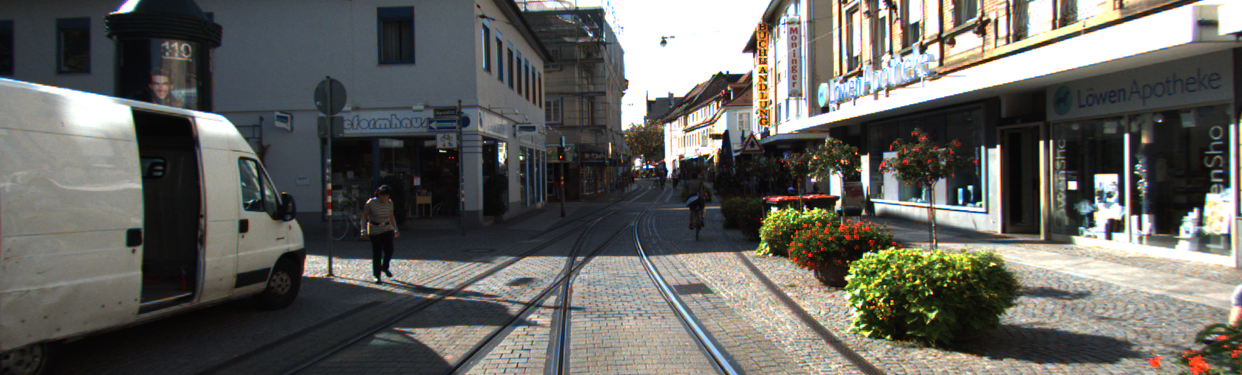

In [40]:
Image.open('../kitti_dataset/training/image_2/000100.png')

In [41]:
with open('../kitti_dataset/training/calib/000100.txt') as f:
    print f.read()

P0: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 0.000000000000e+00 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P1: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.875744000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.745884000000e-03
P3: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.395242000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.199936000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.729905000000e-03
R0_rect: 9.999239000000e-01 9.837760000000e-03 -7.445048000000e-03 -9.

In [45]:
with open('../kitti_dataset/training/label_2/000100.txt') as f:
    print f.read()

Van 0.63 0 -0.90 0.00 58.65 320.90 374.00 2.46 2.03 5.35 -5.18 1.69 7.24 -1.51
Cyclist 0.00 0 -1.58 684.31 165.66 710.23 242.31 1.82 0.59 1.89 2.13 1.66 18.06 -1.47
Pedestrian 0.00 0 0.84 359.32 182.26 400.32 285.85 1.57 0.52 0.62 -3.63 1.72 11.35 0.54
Car 0.00 2 -2.46 19.88 179.87 206.64 238.00 1.44 1.62 3.91 -13.04 1.64 18.98 -3.05
DontCare -1 -1 -10 650.19 158.35 666.90 192.77 -1 -1 -1 -1000 -1000 -1000 -10

